# Tutorial - examples of all metrics

This notebook shows the functionality of the different metrics included in the library. 

For this purpose, we use a pre-trained ResNet-18 model and X dataset.

In [24]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#torch==1.8.0 torchvision==0.9.0.

# Imports general.
import sys
import warnings
import gc
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preliminaries

### Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [2]:
# Load test data and make loaders.
test_set = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/imagenet_images',
                                            transform=transforms.Compose([transforms.Resize(256),
                                                                          transforms.CenterCrop((224, 224)),
                                                                          transforms.ToTensor(),
                                                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=24)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

### Load a torch model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [3]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
            
    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())
    
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

# Evaluate model performance.
#print(f"\nModel test accuracy: {(100 * evaluate_model(model.to(device), test_loader, device)):.2f}%")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Generate attribution-based explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [4]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(model, x_batch, y_batch, explanation_func="IntegratedGradients")

In [5]:
# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

## Evaluation using `quantus`

As a preliminary step to evaluating the explanations using all the available metrics in the library, we will first view what categories and metrics we have available.

In [6]:
# Let's view what metrics categories are available.
quantus.available_categories()

['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [7]:
# In each category, let's view the available metrics.
metrics = quantus.available_metrics()
metrics

{'Axiomatic': ['Completeness Test',
  'Symmetry',
  'InputInvariance',
  'Sensitivity',
  'Dummy'],
 'Complexity': ['Sparseness Test', 'Complexity Test', 'Effective Complexity'],
 'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity Arya',
  'Monotonicity Nguyen',
  'Infidelity',
  'Selectivity',
  'SensitivityN',
  'IROF'],
 'Localisation': ['Pointing Game',
  'TKI',
  'Relevance Mass Accuracy',
  'Relevance Mass Ranking',
  'Attribution Localization '],
 'Randomisation': ['Model Parameter Randomisation Test', 'Random Logit Test'],
 'Robustness': ['Continuity Test',
  'Input Independence Rate',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity']}

#### Faithfulness metrics 

Score explanations using the faithfulness metrics:

* Faithfulness Correlation by Bhatt et al., 2020
* Faithfulness Estimate by Alvarez-Melis et al., 2018, 2019
* Pixel-Flipping by Bach et al., 2015
* Region Segmentation by Samek et al., 2015
* Monotonicity-Arya by Arya et al., 2019
* Monotonicity-Nguyen by Nguyen et al., 2019
* Infidelity by Yeh et al., 2010
* Selectivity by Montavan et al., 2018
* SensitivityN by Ancona et al., 2018
* IROF by Rieger et al., 2020

In [8]:
# Return faithfulness correlation scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessCorrelation(**{
    "nr_runs": 100,  
    "subset_size": 224,  
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,    
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[0.008247843308351257]

In [9]:
# Return faithfulness estimate scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessEstimate(**{
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,
    "img_size": 224,  
    "features_in_step": 224,  
    "perturb_baseline": "black",  
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[-0.4954784109205682,
 0.29186972621452156,
 -0.6104373038233553,
 0.44562116204964336,
 -0.18515026254488148,
 0.5991871403247081,
 -0.09581473471879877,
 0.27836164287872744,
 -0.806657292048534,
 0.4690633516730346,
 0.2136399836372414,
 -0.4335101785821722,
 -0.2358054414126979,
 -0.36982057717635836,
 -0.29276373419422086,
 0.47064097900209606,
 0.36948481705724,
 -0.03290739789466504,
 -0.1263222277302161,
 0.6581636380629612,
 0.3145480491801773,
 -0.46139662656095176,
 0.6177340642074052,
 0.28108989449807104]

In [16]:
# TODO. Bug fixes.
'''
# Return infidelity scores in an one-liner - by calling the metric instance.
quantus.Infidelity(**{
    "loss_func": quantus.mse,
    "img_size": 224,
    "perturb_patch_sizes": [8, 14, 28],
    "perturb_baseline": "black",  
    "perturb_func": quantus.baseline_replacement_by_patch,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})
''';

In [10]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityArya(**{
    "features_in_step": 224,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [11]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityNguyen(**{
    "n_samples": 100,
    "perturb_baseline": "uniform",
    "features_in_step": 224,
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[0.329149049754431,
 0.046501174460815725,
 -0.45245035233824477,
 0.0577204783258595,
 0.38266175528507373,
 0.2274450138799915,
 0.3318257527226137,
 0.2739686098654709,
 -0.15624813153961137,
 0.0648120862694854,
 0.17808562887038223,
 -0.13005765534913516,
 0.22100576553491355,
 -0.0011926115737774933,
 0.06051249199231263,
 0.34980888319453346,
 -0.14267777065983345,
 0.5495547725816785,
 0.3650928891736067,
 0.09496374917989245,
 0.3946562032884904,
 0.10599402092675637,
 0.2230172966047406,
 0.06171471279094599]

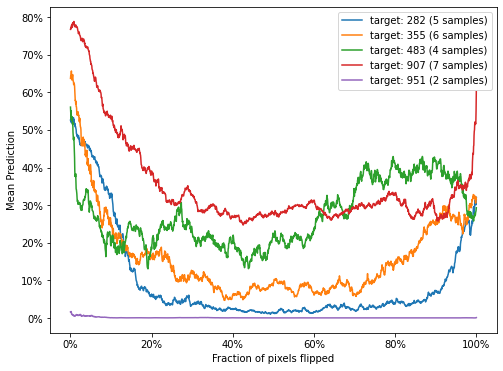

In [12]:
# Return pixel-flipping scores in an one-liner - by calling the metric instance.
scores = quantus.PixelFlipping(**{
    "features_in_step": 28,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

# Plot example!
quantus.plot_pixel_flipping_experiment(y_batch=y_batch, scores=scores)

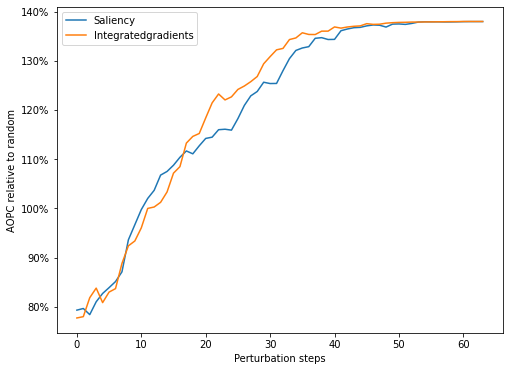

In [210]:
# Return region perturbation scores in an one-liner - by calling the metric instance.
results = {method: quantus.RegionPerturbation(**{
    "patch_size": 28,
    "regions_evaluation": 100,
    "img_size": 224,
    "random_order": False,
    "perturb_func": quantus.baseline_replacement_by_patch,
    "perturb_baseline": "uniform",  
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
quantus.plot_region_perturbation_experiment(results=results)

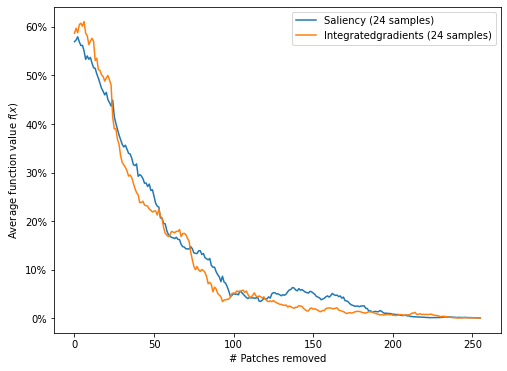

In [253]:
# Return selectivity scores in an one-liner - by calling the metric instance.
results = {method: quantus.Selectivity(**{
    "patch_size": 14,
    "perturb_func": quantus.baseline_replacement_by_patch,
    "perturb_baseline": "black",  
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
quantus.plot_selectivity_experiment(results=results)

No handles with labels found to put in legend.


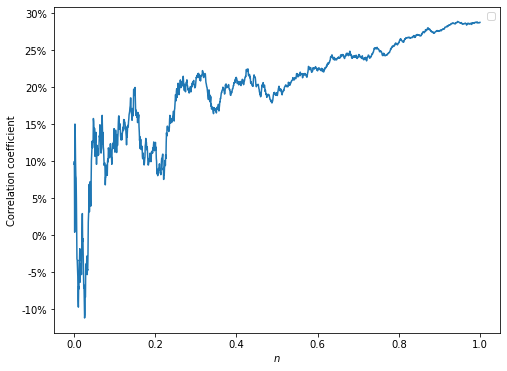

In [215]:
# Return sensitivity-n scores in an one-liner - by calling the metric instance.
scores = quantus.SensitivityN(**{
    "features_in_step": 28,
    "n_max_percentage": 0.8,
    "img_size": 224,
    "similarity_func": quantus.correlation_pearson,
    "perturb_func": quantus.baseline_replacement_by_indices,
    "perturb_baseline": "uniform",  
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

# Plot example!
quantus.plot_sensitivity_n_experiment(results=scores)

In [198]:
# Return IFOF scores in an one-liner - by calling the metric instance.
results = {method: quantus.IROF(**{
    "segmentation_method": "slic",
    "perturb_baseline": "mean",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Gradient", "Saliency", "IntegratedGradients", "GradientShap"]}

results

{'Gradient': [68.20079040993858],
 'GradientShap': [68.22271214744474],
 'IntegratedGradients': [68.2321012141051],
 'Saliency': [68.20052606718771]}

#### Robustness metrics 

Score explanations using the robustness metrics:

* Continuity by Montavan et al., 2017
* Input Independence Rate by Yang et al., 2019
* Local Lipschitz Estimate by Alvarez-Melis et al., 2018a; 2018b
* Max-Sensitivity by Yeh at el., 2019
* Avg-Sensitivity by Yeh at el., 2019

In [265]:
# Return continuity scores in an one-liner - by calling the metric instance.
quantus.Continuity(**{
    "nr_patches": 4,
    "nr_steps": 10,
    "img_size": 224,
    "perturb_baseline": "black",
    "explain_func": quantus.explain,
    "similarity_func": quantus.correlation_spearman,
    "perturb_func": quantus.translation_x_direction,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "IntegratedGradients", "device": device})

#print(f"Continutity correlation score: {continuity_test.continutity_correlation_score:.4f}")

{0: {0: [577.7979751610161,
   706.6898748537778,
   346.378437354894,
   216.1303507599483,
   98.18202624117396,
   59.55836787177233,
   64.90982456487892,
   57.42351891128857,
   70.25708734119036,
   131.34715485457275],
  1: [303.4536451536255,
   655.0719298115124,
   556.3070009471604,
   749.0770231555389,
   683.7981647921387,
   597.1171384504682,
   686.190947852007,
   445.425309519532,
   369.1882246129751,
   387.56122697772935],
  2: [165.59453993368373,
   259.52682459268067,
   144.91922435584064,
   124.02409223428826,
   70.46874975761877,
   38.45954619099987,
   44.87167999662283,
   54.12275939649305,
   60.8701798679117,
   118.62974727389576],
  3: [69.08679666020372,
   134.1589362073579,
   133.03681543626354,
   171.55831331721743,
   187.82969146161346,
   201.15675410911058,
   331.78734697534526,
   337.8371560769365,
   306.9419787320784,
   338.4341922560234],
  4: [14.83487606048584,
   12.82431411743164,
   12.920865058898926,
   14.523674011230469,


In [289]:
# Return local lipschitzEstimate estimate scores in an one-liner - by calling the metric instance.
quantus.LocalLipschitzEstimate(**{
    "nr_samples": 10,
    "perturb_std": 0.1,
    "norm_numerator": quantus.distance_euclidean,
    "norm_denominator": quantus.distance_euclidean,
    "explain_func": quantus.explain,
    "perturb_func": quantus.gaussian_noise,
    "similarity_func": quantus.lipschitz_constant,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[50.15209014701567,
 86.71000118198772,
 73.06995745304724,
 45.10286235202501,
 76.65113855029979,
 98.90986800348847,
 80.62670902459955,
 86.79703493517994,
 82.81693752539626,
 58.884838393672034,
 78.04416827883546,
 76.8225617703861,
 86.35849218276287,
 131.09557874578823,
 79.87290006237474,
 59.45172171107881,
 89.73012805404606,
 43.95301669247918,
 79.66593591080655,
 56.231468654493256,
 56.020271582416996,
 87.47287146787427,
 71.90555142500843,
 98.4862371573308]

In [283]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "explain_func": quantus.explain,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[0.017128654,
 0.034615,
 0.02866665,
 0.011896606,
 0.03307318,
 0.06139419,
 0.051570114,
 0.028542856,
 0.027542109,
 0.018767621,
 0.014477151,
 0.030449748,
 0.03863772,
 0.069662556,
 0.03108715,
 0.017437855,
 0.048724156,
 0.021958254,
 0.037339058,
 0.017925242,
 0.02814223,
 0.02422402,
 0.05357002,
 0.05848489]

In [ ]:
# TODO. Remove from library - iteration 1.
'''
# Return input independence rate scores in an one-liner - by calling the metric instance.
quantus.InputIndependenceRate(**{
    "similarity_func": abs_difference,
    "perturb_func": optimization_scheme, # TODO.
    "perturb_std": 0.01,
    "threshold": 0.025, # 0.1
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"explanation_func": explain, "method": method, "device": device})
''';

In [284]:
# Return avg sensitivity scores in an one-liner - by calling the metric instance.
quantus.AvgSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "explain_func": quantus.explain,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[0.01314044464379549,
 0.02956504002213478,
 0.022758642211556435,
 0.010920989327132702,
 0.026310700923204422,
 0.04821241647005081,
 0.04254944995045662,
 0.018712272867560387,
 0.02596506103873253,
 0.01302288193255663,
 0.011878075078129768,
 0.026176387444138527,
 0.03328707069158554,
 0.06417575478553772,
 0.024419452995061874,
 0.016335610300302505,
 0.03950711339712143,
 0.014827529899775982,
 0.02974311076104641,
 0.013994783163070679,
 0.02408171072602272,
 0.018815387040376663,
 0.038599733263254166,
 0.04724549129605293]

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = SparsenessTest()(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch,
   a_batch=a_batch,
   **{"explanation_func": method, "device": device})

scores

[0.4068544910493193,
 0.40403445669812693,
 0.481418430522996,
 0.43348663807612225,
 0.4469029816861512,
 0.4869256708564608,
 0.4346094099015184,
 0.44411300714858515,
 0.41899337281779514,
 0.43024956158126776,
 0.5012424486664208,
 0.4757315614566706,
 0.40789886602229375,
 0.4213190000559146,
 0.5673514217398928,
 0.3811969144468322,
 0.509078128818867,
 0.47547261337752417,
 0.42619295887745434,
 0.4507217762296288,
 0.4047523814239077,
 0.4293180322968817,
 0.4595081011092839,
 0.4814590122244766]

### Localisation metrics

In [ ]:
# TODO. Testing and src code clean-up of metrics.

### Randomisation metrics

In [ ]:
# TODO. Testing and src code clean-up of metrics.

### Complexity metrics

In [ ]:
# TODO. Testing and src code clean-up of metrics.

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = ComplexityTest()(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch,
   a_batch=a_batch,b
   **{"explanation_func": method, "device": device})

scores

### Axiomatic metrics

In [ ]:
# TODO. Testing and src code clean-up of metrics.

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = CompletenessTest(**{"output_transformation_func": lambda x: x})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch,
   a_batch=a_batch,
   **{"explanation_func": method, "device": device})

scores